In [405]:
import pandas as pd

data = pd.read_csv('../../datasets/insurance_train.csv')
print(data)

     age     sex     bmi  children smoker     region      charges
0     26    male  27.060         0    yes  southeast  17043.34140
1     58    male  36.955         2    yes  northwest  47496.49445
2     20  female  24.420         0    yes  southeast  26125.67477
3     51  female  38.060         0    yes  southeast  44400.40640
4     62  female  25.000         0     no  southwest  13451.12200
..   ...     ...     ...       ...    ...        ...          ...
333   25  female  22.515         1     no  northwest   3594.17085
334   18    male  53.130         0     no  southeast   1163.46270
335   64    male  37.905         0     no  northwest  14210.53595
336   54  female  47.410         0    yes  southeast  63770.42801
337   28  female  25.800         0     no  southwest   3161.45400

[338 rows x 7 columns]


# 1. Подготовка данных
## 1. проверить наличие пропусков и выбросов
Для проверки выбросов воспользуюсь интерквартильным размахом, отсекая значения, расположенные вне границы [Q1 - 1.5 * IQR, Q2 + 1.5 * IQR].

In [406]:
print("Количество пропусков в столбце:")
print(data.isnull().sum())
print()

numeric_cols = ["age", "bmi", "children", "charges"]

for col in numeric_cols:
    Q1 = data[col].quantile(0.25)
    Q3 = data[col].quantile(0.75)
    IQR = Q3 - Q1
    
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    count_outliers = ((data[col] < lower_bound) | (data[col] > upper_bound)).sum()
    
    print(f"{col}: выбросов = {count_outliers}")

Количество пропусков в столбце:
age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

age: выбросов = 0
bmi: выбросов = 5
children: выбросов = 0
charges: выбросов = 19


## 2. привести признаки к числовым
Категориальные признаки:

In [407]:
data_encoded = pd.get_dummies(data, columns=['region'], drop_first=False)
print(data_encoded)

     age     sex     bmi  children smoker      charges  region_northeast  \
0     26    male  27.060         0    yes  17043.34140             False   
1     58    male  36.955         2    yes  47496.49445             False   
2     20  female  24.420         0    yes  26125.67477             False   
3     51  female  38.060         0    yes  44400.40640             False   
4     62  female  25.000         0     no  13451.12200             False   
..   ...     ...     ...       ...    ...          ...               ...   
333   25  female  22.515         1     no   3594.17085             False   
334   18    male  53.130         0     no   1163.46270             False   
335   64    male  37.905         0     no  14210.53595             False   
336   54  female  47.410         0    yes  63770.42801             False   
337   28  female  25.800         0     no   3161.45400             False   

     region_northwest  region_southeast  region_southwest  
0               False      

Бинарные признаки:

In [408]:
data_transformed = data_encoded
data_transformed['sex'] = data_encoded['sex'].map({'male': 1, 'female': 0})
data_transformed['smoker'] = data_encoded['smoker'].map({'yes': 1, 'no': 0})
print(data_transformed)

     age  sex     bmi  children  smoker      charges  region_northeast  \
0     26    1  27.060         0       1  17043.34140             False   
1     58    1  36.955         2       1  47496.49445             False   
2     20    0  24.420         0       1  26125.67477             False   
3     51    0  38.060         0       1  44400.40640             False   
4     62    0  25.000         0       0  13451.12200             False   
..   ...  ...     ...       ...     ...          ...               ...   
333   25    0  22.515         1       0   3594.17085             False   
334   18    1  53.130         0       0   1163.46270             False   
335   64    1  37.905         0       0  14210.53595             False   
336   54    0  47.410         0       1  63770.42801             False   
337   28    0  25.800         0       0   3161.45400             False   

     region_northwest  region_southeast  region_southwest  
0               False              True            

## 3. вычислить парные корреляции признаков

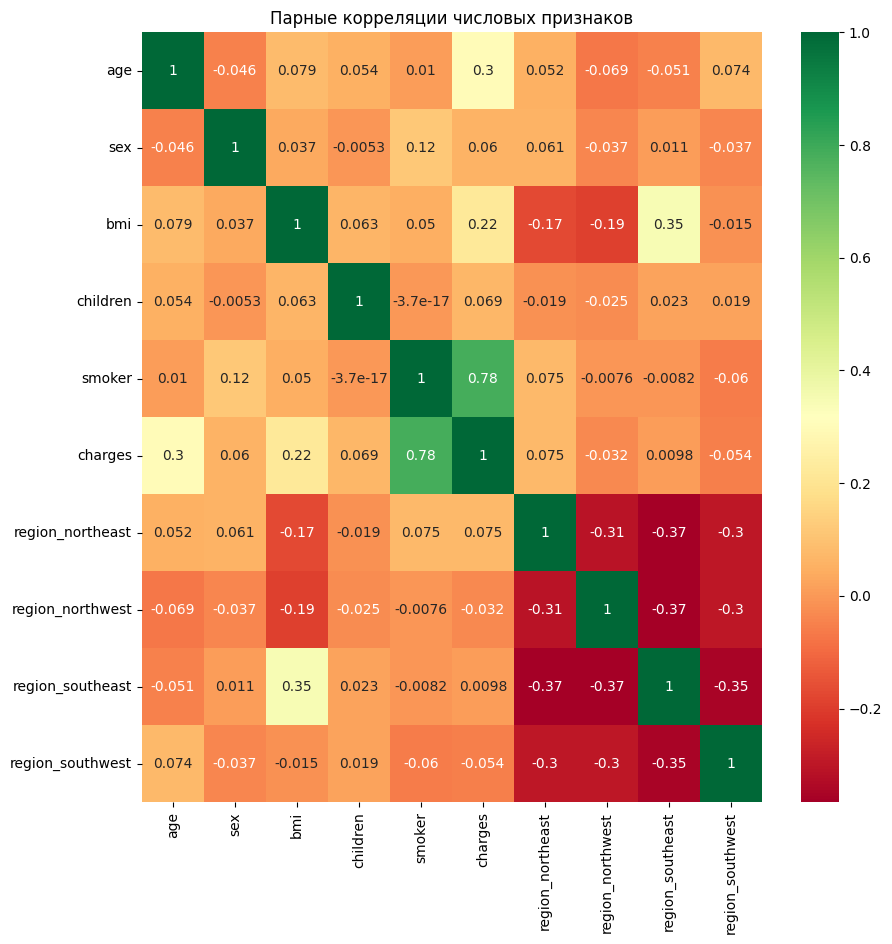

In [409]:
import seaborn as sns
import matplotlib.pyplot as plt

correlation_matrix = data_transformed.corr()
plt.figure(figsize=(10, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='RdYlGn')
plt.title("Парные корреляции числовых признаков")
plt.show()

# 2. Многомерная линейная регрессия

## 1. Аналитическое построение

### Матрица объектов и признаков

Матрица объекты-признаки $X$ размера $\ell \times n$, где $\ell$ - чило объектов выборке, а каждый оъект описывается $n$ признаками. Параметры модели $w$ - вектор стобец размера $n$.

Модель:

$$
f(x, w) = \sum_{i=1}^{n} w_i x_i = Xw
$$

$f(x, w)$ — предсказание модели для объекта $x$.

Функционал потерь:

$$
Q(w) = \sum_{i=1}^{\ell} (f(x_i, w) - y_i)^2 = ||Xw - y||^2 \rightarrow \min_w
$$

Это сумма квадратов ошибок. Используется с целью уменьшения общей ошибки.


Градиент функционала потерь:

$$
\frac{\partial Q}{\partial w} = 2X^T(Xw - y)
$$

Градиент — это вектор частных производных по каждому параметру $w_i$.
Он показывает направление наискорейшего роста функции в данной точке. В стационарных точках градиент равен 0, т.к. в этих точках функция ни возрастает, ни убывает.

Аналитическое решение:

$$
2X^T(Xw-y) = 0
$$

$$
X^TXw = X^Ty
$$

$$
w^* = (X^TX)^{-1}X^Ty
$$

$w^*$ — коэффициенты, которые минимизируют ошибку. 


Если матрица $X^TX$ вырождена (необратима), тогда $(X^TX)^{-1}$ не существует.

В таких случаях используют численные методы, например градиентный спуск.

In [410]:
import numpy as np

X_raw = data_transformed[['age', 'sex', 'bmi', 'children', 'smoker',
                    'region_northwest', 'region_southeast', 'region_southwest']]
X_raw.insert(0, 'wFreeMember', 1)

y_raw = data_transformed['charges']

X = X_raw.values.astype(float)
y = y_raw.values.reshape(-1, 1).astype(float)

w_analytical = np.linalg.inv(X.T @ X) @ X.T @ y

print("Коэффициенты модели w при аналитическом решении:")
for col, coef in zip(X_raw.columns, w_analytical.flatten()):
    print(f"{col}: {coef:.2f}")

Коэффициенты модели w при аналитическом решении:
wFreeMember: -11458.01
age: 256.71
sex: -655.41
bmi: 350.86
children: 483.10
smoker: 23401.99
region_northwest: -200.59
region_southeast: -1389.90
region_southwest: -1440.51


## 2. численное построение, с помощью метода градиентного спуска

Основная идея состоит в итерационном движении от одной точки к другой в пространстве параметров модели. Направление движения определяется с помощью градиента функции. Он в некоторой точке указывает направление наискорейшего роста. Мы же хотим минимизировать функцию, поэтому направление выберем как минус градиент в этой точке. Размер шага будет определяться абсолютным значением градиента в точке и некоторым параметром.

1. Мы начинаем с начального приближения $w^{(0)}$ в пространстве параметров модели.
2. В каждой точке вычисляем градиент функции потерь:

$$
\frac{\partial Q}{\partial w}
$$

3. Вычисляем новое приближение вектора $w$
* $w^{(k+1)} = w^{(k)} - \lambda \cdot \frac{\partial Q}{\partial w}|_{w=w^{(k)}}$

Остановка просходит в случаях:
* градиент близок к нулю
* изменение параметров близко к нулю
* достигнуто ограничительное число итераций

In [411]:
lambda_ = 1e-6       
epsilon = 1e-6        
max_iter = 1_000_000 

w_numeric = np.zeros((X.shape[1], 1))

for i in range(max_iter):
    grad = 2 * X.T @ (X @ w_numeric - y)
    
    w_new = w_numeric - lambda_ * grad
    
    if np.linalg.norm(grad) < epsilon or np.linalg.norm(w_new - w_numeric) < epsilon:
        break
    
    w_numeric = w_new

print("\nКоэффициенты w при численном решении):")
for col, coef in zip(X_raw.columns, w_numeric.flatten()):
    print(f"{col}: {coef:.2f}")


Коэффициенты w при численном решении):
wFreeMember: -11457.95
age: 256.71
sex: -655.41
bmi: 350.86
children: 483.10
smoker: 23401.99
region_northwest: -200.60
region_southeast: -1389.90
region_southwest: -1440.52


# 3. Добавление регуляризации

В случае сильной корреляции между признаками (столбцами матрицы $X$), обращение матрицы $(X^TX)^{-1}$ ведет к увеличению её абсолютных значений (а в случае полной линейной зависимости — вообще необратимости), и в результате веса модели становятся большими по модулю и неустойчивыми.
Бороться с этим эффектом можно с помощью регуляризации. В функционал ошибки добавляют слагаемое, пропорциональное норме весов. Таким образом можно получить различные модификации регрессионной модели.

**Гребневая регрессия**
$$
Q_{L_2}(w) = ||Xw - y||^2 + \alpha ||w||_2^2 \rightarrow \min_{w}
$$

$$
||a||_2 = \sqrt{\sum_{i=1}^{n} a_i^2}
$$

Имеет аналитическое решение
$$
w^* = (X^TX + \alpha I)^{-1}X^Ty
$$
где $I$ — единичная матрица

In [ ]:
alpha = 0.05
I = np.eye(X.shape[1])

w_ridge_analytical = np.linalg.inv(X.T @ X + alpha * I) @ X.T @ y

print("\nКоэффициенты модели w при аналитическом решении с регуляризацией:")
for col, coef in zip(X_raw.columns, w_ridge_analytical.flatten()):
    print(f"{col}: {coef:.4f}")


Коэффициенты модели w при аналитическом решении с регуляризацией:
wFreeMember: -11396.2440
age: 256.4056
sex: -656.6369
bmi: 349.5866
children: 482.2760
smoker: 23381.2414
region_northwest: -208.2910
region_southeast: -1389.7042
region_southwest: -1444.5482


**Градиент**
$$
\frac{\partial Q_{L_2}}{\partial w} = 2 X^T (Xw - y) + 2 \alpha w
$$

In [413]:
lambda_ = 1e-6       
epsilon = 1e-6        
max_iter = 1_000_000

w_ridge_numeric = np.zeros((X.shape[1], 1))

for i in range(max_iter):
    grad = 2 * X.T @ (X @ w_ridge_numeric - y) + 2 * alpha * w_ridge_numeric
    
    w_new = w_ridge_numeric - lambda_ * grad
    
    if np.linalg.norm(grad) < epsilon or np.linalg.norm(w_new - w_ridge_numeric) < epsilon:
        break
    
    w_ridge_numeric = w_new

print("\nКоэффициенты модели w при численном решении с регуляризацией:")
for col, coef in zip(X_raw.columns, w_ridge_numeric.flatten()):
    print(f"{col}: {coef:.2f}")


Коэффициенты модели w при численном решении с регуляризацией:
wFreeMember: -11396.19
age: 256.41
sex: -656.64
bmi: 349.59
children: 482.28
smoker: 23381.24
region_northwest: -208.30
region_southeast: -1389.71
region_southwest: -1444.56


# 4. Оценка обобщающей способности

MSE на тестовых данных:
Константное решение: 141,830,094.36
Аналитическое решение: 34,216,008.76
Численное решение: 34,216,010.77
Ridge аналитическое: 34,221,654.39
Ridge численное: 34,221,656.57


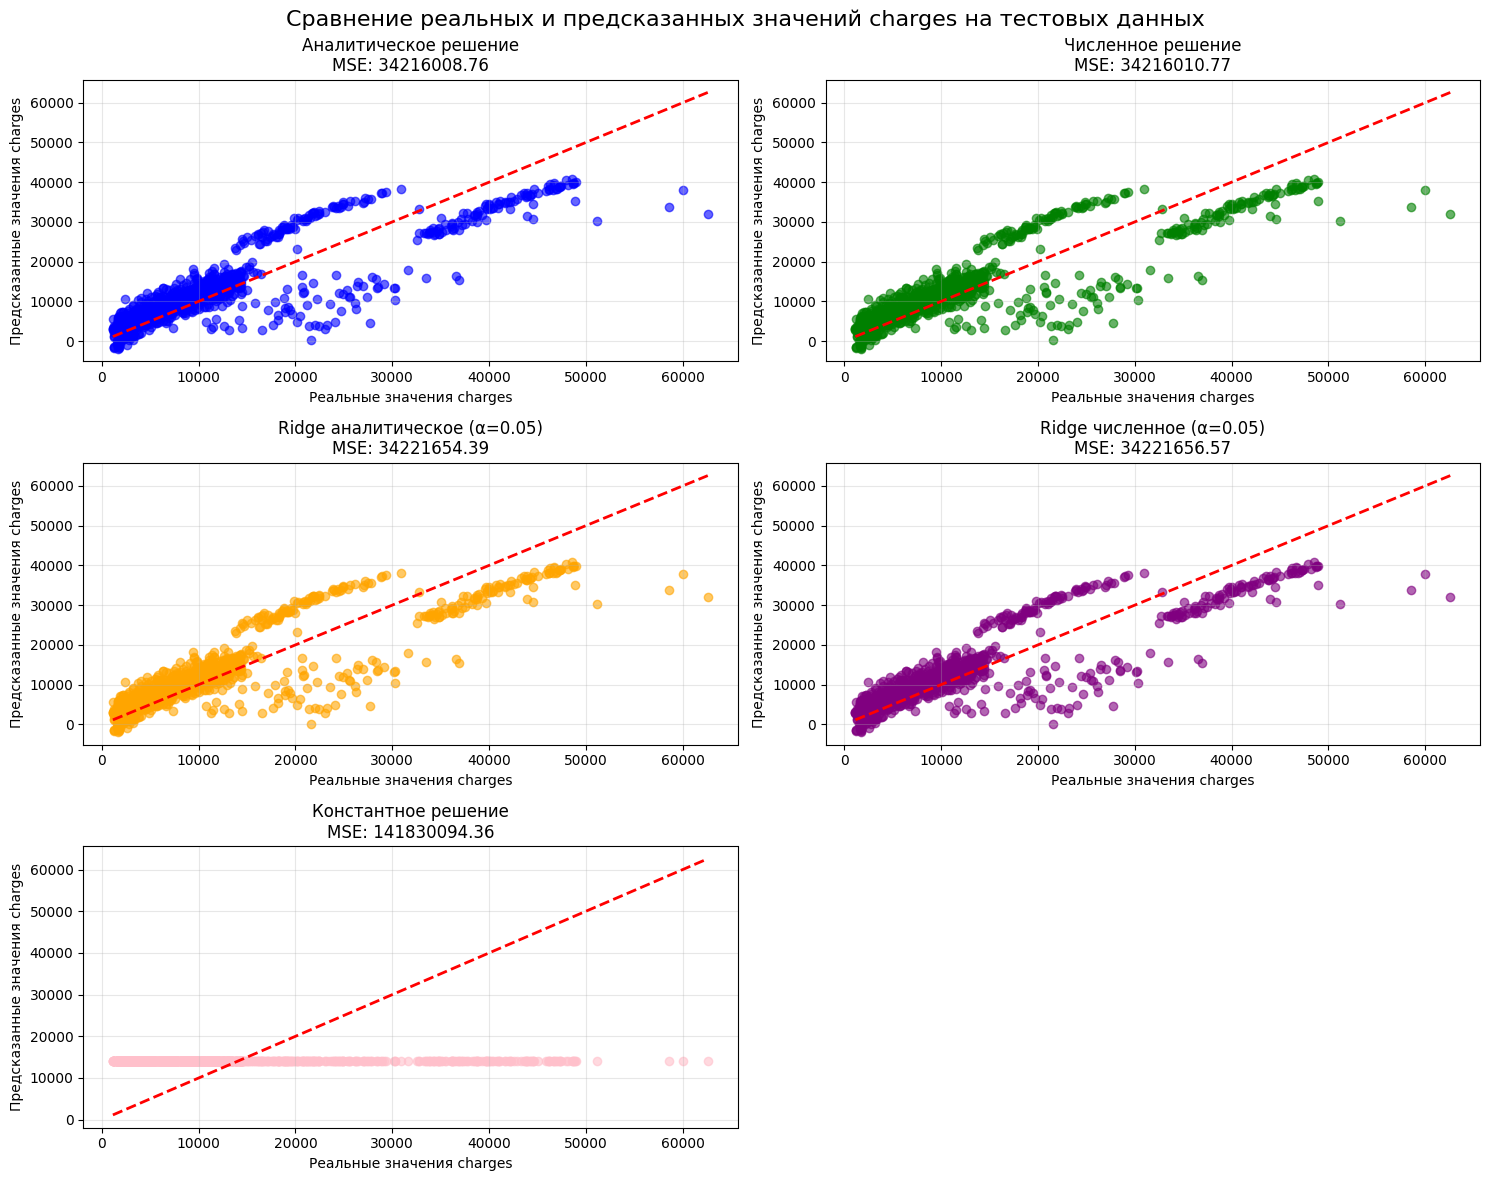

In [414]:
def calculate_mse(y_true, y_pred):
    return np.mean((y_true - y_pred)**2)

df_test = pd.read_csv('../../datasets/insurance_test.csv')

df_test_encoded = pd.get_dummies(df_test, columns=['region'], drop_first=False)
df_test_transformed = df_test_encoded
df_test_transformed['sex'] = df_test_encoded['sex'].map({'male': 1, 'female': 0})
df_test_transformed['smoker'] = df_test_encoded['smoker'].map({'yes': 1, 'no': 0})

X_test_raw = df_test_transformed[['age', 'sex', 'bmi', 'children', 'smoker',
                                'region_northwest', 'region_southeast', 'region_southwest']]
X_test_raw.insert(0, 'wFreeMember', 1)

y_test_raw = df_test_transformed['charges']

X_test = X_test_raw.values.astype(float)
y_test = y_test_raw.values.reshape(-1, 1).astype(float)

y_pred_const = np.mean(y)
y_pred_analytical = X_test @ w_analytical
y_pred_numeric = X_test @ w_numeric
y_pred_ridge_analytical = X_test @ w_ridge_analytical
y_pred_ridge_numeric = X_test @ w_ridge_numeric

mse_const = calculate_mse(y_test, y_pred_const)
mse_analytical = calculate_mse(y_test, y_pred_analytical)
mse_numeric = calculate_mse(y_test, y_pred_numeric)
mse_ridge_analytic = calculate_mse(y_test, y_pred_ridge_analytical)
mse_ridge_numeric = calculate_mse(y_test, y_pred_ridge_numeric)

print("MSE на тестовых данных:")
print(f"Константное решение: {mse_const:,.2f}")
print(f"Аналитическое решение: {mse_analytical:,.2f}")
print(f"Численное решение: {mse_numeric:,.2f}")
print(f"Ridge аналитическое: {mse_ridge_analytic:,.2f}")
print(f"Ridge численное: {mse_ridge_numeric:,.2f}")

fig, axes = plt.subplots(3, 2, figsize=(15, 12))
fig.suptitle('Сравнение реальных и предсказанных значений charges на тестовых данных', fontsize=16)

axes[0, 0].scatter(y_test, y_pred_analytical, alpha=0.6, color='blue')
axes[0, 0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[0, 0].set_xlabel('Реальные значения charges')
axes[0, 0].set_ylabel('Предсказанные значения charges')
axes[0, 0].set_title(f'Аналитическое решение\nMSE: {mse_analytical:.2f}')
axes[0, 0].grid(True, alpha=0.3)

axes[0, 1].scatter(y_test, y_pred_numeric, alpha=0.6, color='green')
axes[0, 1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[0, 1].set_xlabel('Реальные значения charges')
axes[0, 1].set_ylabel('Предсказанные значения charges')
axes[0, 1].set_title(f'Численное решение\nMSE: {mse_numeric:.2f}')
axes[0, 1].grid(True, alpha=0.3)

axes[1, 0].scatter(y_test, y_pred_ridge_analytical, alpha=0.6, color='orange')
axes[1, 0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[1, 0].set_xlabel('Реальные значения charges')
axes[1, 0].set_ylabel('Предсказанные значения charges')
axes[1, 0].set_title(f'Ridge аналитическое (α={alpha})\nMSE: {mse_ridge_analytic:.2f}')
axes[1, 0].grid(True, alpha=0.3)

axes[1, 1].scatter(y_test, y_pred_ridge_numeric, alpha=0.6, color='purple')
axes[1, 1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[1, 1].set_xlabel('Реальные значения charges')
axes[1, 1].set_ylabel('Предсказанные значения charges')
axes[1, 1].set_title(f'Ridge численное (α={alpha})\nMSE: {mse_ridge_numeric:.2f}')
axes[1, 1].grid(True, alpha=0.3)

axes[2, 0].scatter(y_test, np.repeat(y_pred_const, len(y_test)), alpha=0.6, color='pink')
axes[2, 0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[2, 0].set_xlabel('Реальные значения charges')
axes[2, 0].set_ylabel('Предсказанные значения charges')
axes[2, 0].set_title(f'Константное решение\nMSE: {mse_const:.2f}')
axes[2, 0].grid(True, alpha=0.3)

axes[2, 1].axis('off')

plt.tight_layout()
plt.show()